# Prioritization of Risky Test Gaps From Test Gap Reviews

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import numpy as np
import csv
import ast
from dataclasses import dataclass, fields
from typing import Type, TypeVar
from pathlib import Path
from typing import Union, List, Optional, Dict
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import r2_score
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
import pingouin as pg
import os

alpha = 0.05

In [2]:
T = TypeVar('T', bound='GenericRecord')

class GenericRecord:
    """ Generic base class for transforming dataclasses. """
    @classmethod
    def _transform(cls: Type[T], dict_: dict) -> dict:
        """ Convert string values in given dictionary to corresponding type. """
        return {field.name: cls._transform_field(field, dict_[field.name])
                    for field in fields(cls)}
    
    @classmethod
    def _transform_field(cls: Type[T], field, value):
        if field.type is float:
            return float(value.replace(',', '.'))
        return field.type(value)


@dataclass
class CSV_Record(GenericRecord):
    """ Define the fields and their types in a record.
        Field names must match column names in CSV file header.
    """
    project: str
    month: str
    test_gap_assessment: str
    risk_score: float
    score_LEN: float
    score_COM: float
    score_CLI: float
    score_COC: float
    score_ANF: float
    score_NFC: float
    score_ACF: float
    score_CFC: float
    score_RCF: float
    score_RNF: float
    score_CHF: float
    score_CEN: float
    

In [3]:
class Test_Gap:
    def __init__(self, test_gap_assessment, risk_score):
        self.test_gap_assessment = test_gap_assessment
        self.risk_score = risk_score

        if test_gap_assessment == "risky":
            self.assessment_score = 1
        elif test_gap_assessment == "safe":
            self.assessment_score = 0
        else:
            self.assessment_score = -1

    def __str__(self):
        return f'Test_Gap()'


class Assessment:

    def __init__(self, project, month, test_gaps):
        self.project = project
        self.month = month
        self.test_gaps = test_gaps

    def __str__(self):
        return f'Assessment({self.project}-{self.month})'
    

In [4]:
def read_csv_and_get_test_gaps(filename):
    records = []

    with open(filename, 'r', newline='', encoding='latin') as file:
        for i, row in enumerate(csv.DictReader(file, delimiter = ';', quoting=csv.QUOTE_MINIMAL)):
            records.append(CSV_Record._transform(row))
    
    previous_project = ""
    previous_month = ""
    current_project = ""
    current_month = ""

    test_gaps_by_assessments = []

    test_gaps_of_assessment = []

    for record in records:
        current_project = record["project"]
        current_month = record["month"]
        test_gap = Test_Gap(record["test_gap_assessment"], record["risk_score"])
        if current_project == previous_project and current_month == previous_month:
            test_gaps_of_assessment.append(test_gap)
        else:
            if previous_project != "":
                test_gaps_by_assessments.append(Assessment(previous_project,previous_month,test_gaps_of_assessment))
            previous_project=current_project
            previous_month=current_month

            test_gaps_of_assessment = []
            test_gaps_of_assessment.append(test_gap)
    test_gaps_by_assessments.append(Assessment(previous_project,previous_month,test_gaps_of_assessment))

    return test_gaps_by_assessments

## Statistics on Data

In [5]:
def print_stats(test_gaps_by_assessments):
    print('Total number of assessments: %.0f' % len(test_gaps_by_assessments))

    risky_test_gaps = 0
    safe_test_gaps = 0

    project_test_gaps = {}
    project_risky_test_gaps = {}
    project_assessments = {}

    for assessment in test_gaps_by_assessments:
        for test_gap in assessment.test_gaps:
            if test_gap.test_gap_assessment == "risky":
                risky_test_gaps += 1
            elif test_gap.test_gap_assessment == "safe":
                safe_test_gaps += 1
            else:
                raise ValueError('The test_gap_assessment must be either \'risky\' or \'safe\' but was', test_gap["test_gao_assessment"])
    
    total_test_gaps = risky_test_gaps+safe_test_gaps
    print('Total number of test gaps: %.0f' % total_test_gaps)
    print('Safe test gaps: %.0f' % safe_test_gaps)
    print('Risky test gaps: %.0f' % risky_test_gaps)
    scaled_risky_ranks = []
    scaled_safe_ranks = []
    
    assessment_scores = []
    all_risk_scores = []
    
    for assessment in test_gaps_by_assessments:
    
        number_of_risky_gaps = 0
        number_of_gaps = len(assessment.test_gaps)
        assessment_risk_scores = []
        ranks_risky_gaps = []
        ranks_safe_gaps = []
        
        for test_gap in assessment.test_gaps:
            assessment_scores.append(test_gap.assessment_score)
            all_risk_scores.append(test_gap.risk_score)
            assessment_risk_scores.append(test_gap.risk_score)
            number_of_risky_gaps += test_gap.assessment_score
    
        number_of_safe_gaps = number_of_gaps - number_of_risky_gaps
        
        ranks = stats.rankdata(np.array(assessment_risk_scores) * -1 ) # ranking assumes lowest number to be best => multiply by  -1
        zipped = dict(zip(assessment_risk_scores, ranks))

        if assessment.project in project_test_gaps:
            project_test_gaps[assessment.project] = project_test_gaps[assessment.project] + number_of_gaps
            project_risky_test_gaps[assessment.project] = project_risky_test_gaps[assessment.project] + number_of_risky_gaps
            project_assessments[assessment.project] = project_assessments[assessment.project] + 1
        else:
            project_test_gaps[assessment.project] = number_of_gaps
            project_risky_test_gaps[assessment.project] = number_of_risky_gaps
            project_assessments[assessment.project] = 1
            
    
        for test_gap in assessment.test_gaps:
            if test_gap.assessment_score == 1:
                ranks_risky_gaps.append(zipped[test_gap.risk_score])
            else:
                ranks_safe_gaps.append(zipped[test_gap.risk_score])
        
        if( number_of_risky_gaps == 0):
            scaled_risky_rank = 1.0
        elif(number_of_safe_gaps == 0):
            scaled_risky_rank = 0.0
        else:
            best_possible_ranking = (number_of_risky_gaps * (number_of_risky_gaps + 1)) / (2 * number_of_risky_gaps * number_of_gaps)
            worst_possible_ranking = - (number_of_risky_gaps - 2 * number_of_gaps - 1) / (2 * number_of_gaps)
        
            sum_ranks_risky_gaps = sum(ranks_risky_gaps)
            scaled_risky_rank = (( sum_ranks_risky_gaps / (number_of_risky_gaps * ( number_of_gaps))) - best_possible_ranking) / (worst_possible_ranking - best_possible_ranking) # min-max scaling
        
        scaled_risky_ranks.append(scaled_risky_rank)
    
        if( number_of_safe_gaps == 0):
            scaled_safe_rank = 0.0
        elif(number_of_risky_gaps == 0):
            scaled_safe_rank = 1.0
        else:
            best_possible_ranking = (number_of_safe_gaps * (number_of_safe_gaps + 1)) / (2 * number_of_safe_gaps * number_of_gaps)
            worst_possible_ranking = - (number_of_safe_gaps - 2 * number_of_gaps - 1) / (2 * number_of_gaps)
            sum_ranks_safe_gaps = sum(ranks_safe_gaps)
            scaled_safe_rank = (( sum_ranks_safe_gaps / (number_of_safe_gaps * ( number_of_gaps))) - best_possible_ranking) / (worst_possible_ranking - best_possible_ranking) # min-max scaling
        scaled_safe_ranks.append(scaled_safe_rank)
    
    print('Mean 0-1-scaled rank of risky gaps: %.3f' % np.mean(scaled_risky_ranks))
    print('Median 0-1-scaled rank of risky gaps: %.3f' % np.median(scaled_risky_ranks))
    print('Variance 0-1-scaled rank of risky gaps: %.3f' % np.var(scaled_risky_ranks))
    print()
    print('Mean 0-1-scaled rank of safe gaps: %.3f' % np.mean(scaled_safe_ranks))
    print('Median 0-1-scaled rank of safe gaps: %.3f' % np.median(scaled_safe_ranks))
    print('Variance 0-1-scaled rank of safe gaps: %.3f' % np.var(scaled_safe_ranks))

    for project in project_test_gaps:
        print(f'Project {project}, assessments: {project_assessments[project]}, total test gaps: {project_test_gaps[project]}, risky test gaps: {project_risky_test_gaps[project]}')

    return scaled_risky_ranks, scaled_safe_ranks

## Statistical Tests

In [6]:
def print_kendall_and_u(test_gaps_by_assessments):
    scaled_risky_ranks = []
    scaled_safe_ranks = []

    assessment_scores = []
    all_risk_scores = []

    for assessment in test_gaps_by_assessments:

        number_of_risky_gaps = 0
        number_of_gaps = len(assessment.test_gaps)
        assessment_risk_scores = []
        ranks_risky_gaps = []
        ranks_safe_gaps = []

        for test_gap in assessment.test_gaps:
            assessment_scores.append(test_gap.assessment_score)
            all_risk_scores.append(test_gap.risk_score)
            assessment_risk_scores.append(test_gap.risk_score)
            number_of_risky_gaps += test_gap.assessment_score

        number_of_safe_gaps = number_of_gaps - number_of_risky_gaps

        ranks = stats.rankdata(np.array(assessment_risk_scores) * -1 ) # ranking assumes lowest number to be best => multiply by  -1
        zipped = dict(zip(assessment_risk_scores, ranks))

        for test_gap in assessment.test_gaps:
            if test_gap.assessment_score == 1:
                ranks_risky_gaps.append(zipped[test_gap.risk_score])
            else:
                ranks_safe_gaps.append(zipped[test_gap.risk_score])

        if( number_of_risky_gaps == 0):
            scaled_risky_rank = 1.0
        elif(number_of_safe_gaps == 0):
            scaled_risky_rank = 0.0
        else:
            best_possible_ranking = (number_of_risky_gaps * (number_of_risky_gaps + 1)) / (2 * number_of_risky_gaps * number_of_gaps)
            worst_possible_ranking = - (number_of_risky_gaps - 2 * number_of_gaps - 1) / (2 * number_of_gaps)

            sum_ranks_risky_gaps = sum(ranks_risky_gaps)
            scaled_risky_rank = (( sum_ranks_risky_gaps / (number_of_risky_gaps * ( number_of_gaps))) - best_possible_ranking) / (worst_possible_ranking - best_possible_ranking) # min-max scaling
        scaled_risky_ranks.append(scaled_risky_rank)

        if( number_of_safe_gaps == 0):
            scaled_safe_rank = 0.0
        elif(number_of_risky_gaps == 0):
            scaled_safe_rank = 1.0
        else:
            best_possible_ranking = (number_of_safe_gaps * (number_of_safe_gaps + 1)) / (2 * number_of_safe_gaps * number_of_gaps)
            worst_possible_ranking = - (number_of_safe_gaps - 2 * number_of_gaps - 1) / (2 * number_of_gaps)
            sum_ranks_safe_gaps = sum(ranks_safe_gaps)
            scaled_safe_rank = (( sum_ranks_safe_gaps / (number_of_safe_gaps * ( number_of_gaps))) - best_possible_ranking) / (worst_possible_ranking - best_possible_ranking) # min-max scaling
        scaled_safe_ranks.append(scaled_safe_rank)

    res = stats.kendalltau(assessment_scores, all_risk_scores)
    kendall_score = res.statistic
    kendall_p = res.pvalue


    res = stats.mannwhitneyu(scaled_risky_ranks, scaled_safe_ranks, alternative = 'less')
    mannwhitneyu_score = res.statistic
    mannwhitneyu_p = res.pvalue

    print('-----')
    print('Kendall\'s tau statistic: %.3f' % kendall_score)
    print('Kendall\'s tau p-value: %.3f' % kendall_p)


    print('U-test\'s statistic: %.3f' % mannwhitneyu_score)
    print('U-test\'s p-value: %.3f' % mannwhitneyu_p)
    # conclusion 
    if np.average(mannwhitneyu_p) < alpha: 
        print('Reject Null Hypothesis (Significant difference between two samples)') 
    else: 
        print('Do not Reject Null Hypothesis (No significant difference between two samples)')

# Visualization

In [7]:
# From https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a#file-lighten_color-py
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


def draw_kdp(scaled_risky_ranks,scaled_safe_ranks):
    #sns.set_palette("Set1")
    sns.set(style="whitegrid")

    colors = sns.color_palette('Set1')

    risky_color = lighten_color(colors[0], 1.3)
    safe_color = lighten_color(colors[1], 0.7)

    plt.figure(figsize=(8,4))

    ax = sns.histplot({'Risky': scaled_risky_ranks, 'Safe': scaled_safe_ranks}, kde=True,
                      kde_kws={'bw_adjust': 0.4}, multiple='layer', binwidth=0.1,  
                      palette={'Risky': risky_color, 'Safe': safe_color})

    median_risky = np.median(scaled_risky_ranks)
    median_safe = np.median(scaled_safe_ranks)

    # Add median lines
    plt.axvline(median_risky, color=risky_color, linestyle='--') 
    plt.axvline(median_safe, color=safe_color, linestyle='--') 

    # Create legend patches
    patch1 = mpatches.Patch(color=risky_color, label=f'Risky (median: {median_risky:.2f})')
    patch2 = mpatches.Patch(color=safe_color, label=f'Less risky (median: {median_safe:.2f})')
    plt.legend(handles=[patch1, patch2], fontsize=20)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlabel('Test gap ranks (relative)', fontsize=20) 
    plt.ylabel('Density', fontsize=20) 
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Add annotations for best and worst
    ax.annotate('Best\nrank', xy=(0.045, -0.25), xycoords='axes fraction', ha='center', va='center', fontsize=18)
    ax.annotate('Worst\nrank', xy=(0.95, -0.25), xycoords='axes fraction', ha='center', va='center', fontsize=18)

    #plt.title('Kernel Density Plot of Test Gap Ranks', fontsize=14) 

    plt.tight_layout()

# Analysis for all Features

In [8]:
notebook_path = os.path.abspath("Statistics-TestGapRadar-public.ipynb")
p = os.path.join(os.path.dirname(notebook_path), "reviews-public-data.csv")

test_gaps_by_assessments = read_csv_and_get_test_gaps(p)
test_gaps_by_assessments

In [9]:
scaled_risky_ranks, scaled_safe_ranks = print_stats(test_gaps_by_assessments)
scaled_risky_ranks_all = scaled_risky_ranks

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181
Mean 0-1-scaled rank of risky gaps: 0.306
Median 0-1-scaled rank of risky gaps: 0.274
Variance 0-1-scaled rank of risky gaps: 0.051

Mean 0-1-scaled rank of safe gaps: 0.694
Median 0-1-scaled rank of safe gaps: 0.726
Variance 0-1-scaled rank of safe gaps: 0.051
Project subject 5, assessments: 4, total test gaps: 53, risky test gaps: 26
Project subject 3, assessments: 3, total test gaps: 29, risky test gaps: 21
Project subject 4, assessments: 4, total test gaps: 32, risky test gaps: 9
Project subject 1, assessments: 5, total test gaps: 77, risky test gaps: 59
Project subject 2, assessments: 7, total test gaps: 161, risky test gaps: 29
Project subject 6, assessments: 3, total test gaps: 622, risky test gaps: 5
Project subject 7, assessments: 3, total test gaps: 1052, risky test gaps: 28
Project subject 8, assessments: 2, total test gaps: 13, risky test gaps: 4


In [10]:
print_kendall_and_u(test_gaps_by_assessments)

-----
Kendall's tau statistic: 0.289
Kendall's tau p-value: 0.000
U-test's statistic: 127.500
U-test's p-value: 0.000
Reject Null Hypothesis (Significant difference between two samples)


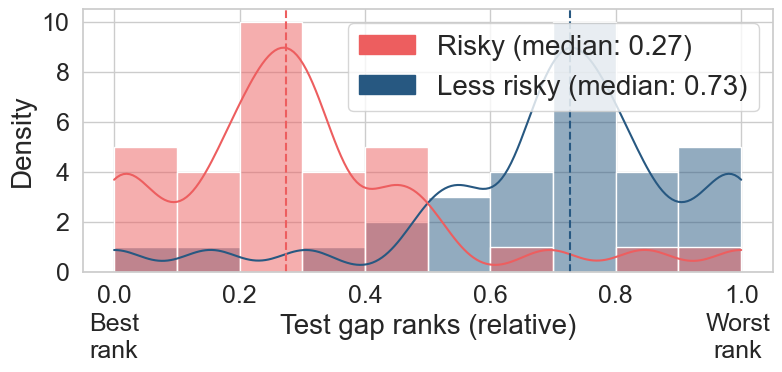

In [11]:
draw_kdp(scaled_risky_ranks,scaled_safe_ranks)